In [1]:
!pip install -q transformers

!pip install -q tqdm scikit-learn pandas
!pip install numpy==1.26.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 299.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
import os


# 모델 저장/불러오기 공통 디렉토리
INTENT_SLOT_MODEL_DIR = os.path.join("best_models", "intent-kobert-v1")

# 개별 파일 경로
MODEL_PATH = os.path.join(INTENT_SLOT_MODEL_DIR, "best_model.pt")
INTENT2IDX_PATH = os.path.join(INTENT_SLOT_MODEL_DIR, "intent2idx.pkl")
SLOT2IDX_PATH = os.path.join(INTENT_SLOT_MODEL_DIR, "slot2idx.pkl")

# 저장 디렉토리 경로만 필요할 경우
SAVE_PATH = INTENT_SLOT_MODEL_DIR

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torch.optim import AdamW
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from collections import Counter


tqdm.pandas()


In [3]:
df = pd.read_csv("intent_slot_dataset_cleaned.csv")
df_extra = pd.read_csv("keyword_boost_slot.csv")
df_combined = pd.concat([df_extra, df]).reset_index(drop=True)

In [4]:
def convert_to_bio_word_level(sentence, slot_json):
    tokens = sentence.split()  # 단어 단위로 토큰화
    labels = ['O'] * len(tokens)

    for slot_name, slot_value in slot_json.items():
        slot_values = slot_value if isinstance(slot_value, list) else [slot_value]
        for val in slot_values:
            if not isinstance(val, str): continue
            val_tokens = val.split()

            for i in range(len(tokens) - len(val_tokens) + 1):
                if tokens[i:i+len(val_tokens)] == val_tokens:
                    labels[i] = f'B-{slot_name}'
                    for j in range(1, len(val_tokens)):
                        labels[i + j] = f'I-{slot_name}'
                    break  # 중복 방지
    return tokens, labels

In [5]:
import ast

bio_data = []

for idx, (_, row) in enumerate(df_combined.iterrows()):
    sentence = str(row['question']).strip()

    if not sentence or sentence.lower() == 'nan':
        continue

    raw_slots = row['slots']

    try:
        if isinstance(raw_slots, str):
            if raw_slots.strip() in ['', '[]', '{}', 'nan']:
                slot_dict = {}
            else:
                # 🔁 문자열 기반 JSON → Python 호환 치환
                cleaned_slot_str = (
                    raw_slots
                    .replace('null', 'None')
                    .replace('true', 'True')
                    .replace('false', 'False')
                )
                slot_dict = ast.literal_eval(cleaned_slot_str)
        elif isinstance(raw_slots, dict):
            slot_dict = raw_slots
        else:
            slot_dict = {}

        tokens, labels = convert_to_bio_word_level(sentence, slot_dict)
        bio_data.append({
            "intent": row["intent"],
            "tokens": tokens,
            "labels": labels
        })

    except Exception as e:
        print("⚠️ Error at row:", idx)
        print("Sentence:", sentence)
        print("Raw slots:", raw_slots)
        print("Error type:", type(e).__name__)
        print("Error message:", str(e))
        print("=" * 60)
        continue

df_bio = pd.DataFrame(bio_data)
df_bio.head()


,intent,tokens,labels
0,airline_info_query,"[항공사, 고객센터]","[B-airline_info, I-airline_info]"
1,airline_info_query,"[항공사, 전화번호]","[B-airline_info, I-airline_info]"
2,airline_info_query,"[항공사, 연락처]","[B-airline_info, I-airline_info]"
3,airline_info_query,"[항공사, 로고]","[B-airline_info, B-airline_info]"
4,airline_info_query,"[항공사, 이미지]","[B-airline_info, B-airline_info]"


In [6]:
intent_labels = sorted(df_bio['intent'].unique())
intent2idx = {label: i for i, label in enumerate(intent_labels)}
idx2intent = {i: label for label, i in intent2idx.items()}

# 1. string → list 변환
df_bio['labels'] = df_bio['labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 2. flatten + B/I 확장
original_labels = set()
for label_list in df_bio['labels']:
    for label in label_list:
        original_labels.add(label)
        # B-xxx가 있으면 I-xxx도 추가
        if label.startswith('B-'):
            original_labels.add('I-' + label[2:])

# 3. 정렬 및 매핑 생성
slot_labels = sorted(original_labels)
slot2idx = {label: i for i, label in enumerate(slot_labels)}
idx2slot = {i: label for label, i in slot2idx.items()}


In [7]:
tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1", use_fast=False)

MAX_LEN = 64

class IntentSlotDataset(Dataset):
    def __init__(self, encodings, slot_labels, intents):
        self.encodings = encodings
        self.slot_labels = slot_labels
        self.intents = intents

    def _mask_pad_tokens(self, slot_labels):
        # PAD 토큰은 보통 O 또는 지정된 pad_index로 처리되어 있음
        # 아래에서는 O의 index를 pad처럼 간주한다면 slot2idx['O']로 처리 가능
        pad_token_label_id = slot2idx.get('PAD', slot2idx['O'])  # 혹시 PAD가 정의되어 있으면 우선
        masked = []
        for seq in slot_labels:
            masked_seq = [label if label != pad_token_label_id else -100 for label in seq]
            masked.append(masked_seq)
        return masked

    def __len__(self):
        return len(self.intents)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.slot_labels[idx])
        item['intent'] = torch.tensor(self.intents[idx])
        return item


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

In [8]:
print(df["intent"].value_counts())

intent
immigration_policy                 578
parking_fee_info                   492
airport_congestion_prediction      410
facility_guide                     396
airport_weather_current            377
parking_location_recommendation    352
parking_congestion_prediction      311
flight_info                        308
parking_availability_query         300
parking_walk_time_info             153
regular_schedule_query             117
baggage_rule_query                 113
airline_info_query                 105
transfer_info                       91
airport_info                        76
baggage_claim_info                  38
default_greeting                    30
transfer_route_guide                19
Name: count, dtype: int64


In [9]:
# 설정
TARGET_INTENT_SAMPLES = 300
TARGET_SLOT_SAMPLES = 300  # 희귀 slot label의 최소 등장 횟수

# 먼저 intent 기준 균형 맞추기
balanced_intent_dfs = []

for intent in df_bio['intent'].unique():
    intent_df = df_bio[df_bio['intent'] == intent]

    if len(intent_df) >= TARGET_INTENT_SAMPLES:
        sampled_df = resample(intent_df, replace=False, n_samples=TARGET_INTENT_SAMPLES, random_state=42)
    else:
        sampled_df = resample(intent_df, replace=True, n_samples=TARGET_INTENT_SAMPLES, random_state=42)

    balanced_intent_dfs.append(sampled_df)

df_balanced_intent = pd.concat(balanced_intent_dfs).reset_index(drop=True)

# 슬롯 라벨 등장 횟수 계산
slot_counter = Counter(label for labels in df_balanced_intent['labels'] for label in labels)

# 부족한 슬롯 라벨 찾기
rare_slots = [label for label, count in slot_counter.items() if count < TARGET_SLOT_SAMPLES]

# 해당 rare slot을 포함하는 샘플만 추출해서 오버샘플링
slot_augmented_dfs = []
for rare_label in rare_slots:
    slot_df = df_bio[df_bio['labels'].apply(lambda x: rare_label in x)]

    if len(slot_df) == 0:
        continue  # 해당 slot이 아예 없는 경우는 건너뜀

    needed = TARGET_SLOT_SAMPLES - slot_counter[rare_label]
    duplicated_df = resample(slot_df, replace=True, n_samples=needed, random_state=42)
    slot_augmented_dfs.append(duplicated_df)

# intent 기반 + slot 보완 데이터 합치기
df_balanced = pd.concat([df_balanced_intent] + slot_augmented_dfs).reset_index(drop=True)

# 결과 확인
print("✅ Intent 분포:")
print(df_balanced['intent'].value_counts())

print("\n✅ Slot label 분포 (상위 20개):")
from collections import Counter
slot_counter_final = Counter(label for labels in df_balanced['labels'] for label in labels)
print(dict(sorted(slot_counter_final.items(), key=lambda x: x[1], reverse=True)[:20]))

✅ Intent 분포:
intent
airport_congestion_prediction      2337
flight_info                        1322
parking_fee_info                   1268
baggage_rule_query                 1253
parking_congestion_prediction      1137
immigration_policy                  957
parking_availability_query          882
regular_schedule_query              869
airport_info                        867
facility_guide                      763
transfer_route_guide                714
airline_info_query                  705
baggage_claim_info                  631
transfer_info                       596
airport_weather_current             435
parking_location_recommendation     373
parking_walk_time_info              360
default_greeting                    300
Name: count, dtype: int64

✅ Slot label 분포 (상위 20개):
{'O': 127783, 'B-parking_lot': 2644, 'B-fee_topic': 2215, 'B-parking_type': 1876, 'B-date': 1632, 'B-luggage_term': 1157, 'B-time_period': 1144, 'B-arrival_airport': 909, 'B-relative_time': 881, 'B-time': 76

In [10]:
def align_labels_with_tokenizer(tokens, labels):
    bert_tokens = []
    aligned_labels = []

    for token, label in zip(tokens, labels):
        sub_tokens = tokenizer.tokenize(token)

        if not sub_tokens:
            sub_tokens = [tokenizer.unk_token]

        bert_tokens.extend(sub_tokens)

        # 첫 sub-token에는 원래 라벨 사용
        aligned_labels.append(label)

        # 나머지 sub-token에 대해서는 label 확장
        for _ in range(1, len(sub_tokens)):
            if label == "O":
                aligned_labels.append("O")
            elif label.startswith("B-"):
                aligned_labels.append("I-" + label[2:])
            elif label.startswith("I-"):
                aligned_labels.append(label)
            else:
                # 예외 처리: label이 'B-', 'I-', 'O' 중 아무 것도 아닐 경우
                aligned_labels.append("O")

    assert len(bert_tokens) == len(aligned_labels), f"Mismatch: {bert_tokens} vs {aligned_labels}"
    return bert_tokens, aligned_labels


In [11]:
def encode_data(df):
    input_ids, attention_masks, slot_label_ids, intent_ids = [], [], [], []

    for _, row in df.iterrows():
        tokens = row["tokens"]
        labels = row["labels"]

        bert_tokens, aligned_labels = align_labels_with_tokenizer(tokens, labels)
        label_ids = [slot2idx[label] for label in aligned_labels]

        if len(bert_tokens) > MAX_LEN - 2:
            bert_tokens = bert_tokens[:MAX_LEN-2]
            label_ids = label_ids[:MAX_LEN-2]

        tokens_input = ['[CLS]'] + bert_tokens + ['[SEP]']
        label_ids = [slot2idx['O']] + label_ids + [slot2idx['O']]

        input_id = tokenizer.convert_tokens_to_ids(tokens_input)
        attention_mask = [1] * len(input_id)

        pad_len = MAX_LEN - len(input_id)
        input_id += [0] * pad_len
        attention_mask += [0] * pad_len
        label_ids += [slot2idx['O']] * pad_len

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        slot_label_ids.append(label_ids)
        intent_ids.append(intent2idx[row["intent"]])

    encodings = {
        "input_ids": input_ids,
        "attention_mask": attention_masks
    }
    return encodings, slot_label_ids, intent_ids

# ✅ Train / Val split
train_df, val_df = train_test_split(df_balanced, test_size=0.1, stratify=df_balanced['intent'])

# ✅ Encode
train_encodings, train_slot_labels, train_intents = encode_data(train_df)
val_encodings, val_slot_labels, val_intents = encode_data(val_df)

# ✅ Dataset / DataLoader
train_dataset = IntentSlotDataset(train_encodings, train_slot_labels, train_intents)
val_dataset = IntentSlotDataset(val_encodings, val_slot_labels, val_intents)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [12]:
from collections import Counter
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 전체 slot label 모으기 (train_dataset 기준)
all_slot_labels = [
    label for data in train_dataset
    for label in data['labels'].tolist()
    if label != -100
]

slot_counts = Counter(all_slot_labels)
total = sum(slot_counts.values())

# slot2idx 기준으로 weight 생성
slot_weights = []
for idx in range(len(slot2idx)):
    count = slot_counts.get(idx, 0)
    if count == 0:
        slot_weights.append(0.0)  # 안 쓰인 경우 0
    else:
        slot_weights.append(1.0 / count)

slot_weights = torch.tensor(slot_weights).float().to(device)

In [13]:
print(f"Slot label 개수: {len(slot2idx)}")
print(f"slot_weights shape: {slot_weights.shape}")
slot_weights

Slot label 개수: 81
slot_weights shape: torch.Size([81])


tensor([3.6765e-03, 1.7730e-03, 1.7007e-03, 3.7313e-03, 2.0921e-03, 1.2255e-03,
        2.2124e-03, 3.2680e-03, 3.8023e-03, 2.1645e-03, 1.8727e-03, 6.8446e-04,
        2.5189e-03, 1.4970e-03, 2.4038e-03, 3.3784e-03, 1.7212e-03, 5.0378e-04,
        1.8484e-03, 2.8818e-03, 3.5211e-03, 1.7361e-03, 2.6810e-03, 9.5877e-04,
        1.6694e-03, 3.7313e-03, 5.5556e-02, 3.3223e-03, 4.1946e-04, 5.9242e-04,
        3.0769e-03, 3.6496e-03, 1.2674e-03, 3.4014e-03, 3.5587e-03, 1.4535e-03,
        9.8135e-04, 3.6630e-03, 1.5898e-03, 3.1447e-03, 3.6765e-03, 1.0593e-03,
        2.2026e-03, 2.0202e-03, 4.8286e-04, 5.6275e-04, 2.2124e-03, 1.2500e-02,
        3.8023e-03, 2.7624e-03, 7.4239e-04, 1.5244e-03, 1.2771e-03, 0.0000e+00,
        2.4038e-03, 1.1261e-03, 9.0827e-04, 7.1225e-04, 7.1429e-02, 0.0000e+00,
        0.0000e+00, 6.9784e-04, 2.6810e-03, 7.1124e-04, 0.0000e+00, 2.0243e-03,
        0.0000e+00, 0.0000e+00, 2.0354e-04, 0.0000e+00, 2.1739e-02, 0.0000e+00,
        8.2850e-04, 4.3478e-02, 3.0303e-

In [14]:
# ✅ 🔍 디버깅 출력 (encode_data 밖에 위치)
sample_idx = 6
print("🧾 Original Tokens:", train_df.iloc[sample_idx]['tokens'])
print("🔖 Labels:", train_df.iloc[sample_idx]['labels'])
print("🧠 BERT Tokens:", tokenizer.tokenize(" ".join(train_df.iloc[sample_idx]['tokens'])))
print("📦 Tokens after adding [CLS]/[SEP]:", train_encodings['input_ids'][sample_idx])
print("🧱 Attention Mask:", train_encodings['attention_mask'][sample_idx])
print("🎯 Intent:", train_intents[sample_idx])

🧾 Original Tokens: ['내년', '겨울', '에', '운항', '예정', '인', '비행기', '알려주세요']
🔖 Labels: ['O', 'B-season', 'O', 'O', 'O', 'O', 'O', 'O']
🧠 BERT Tokens: ['▁내년', '▁겨울', '▁', '에', '▁운항', '▁예정', '▁인', '▁비행기', '▁알려', '주세요']
📦 Tokens after adding [CLS]/[SEP]: [2, 1437, 930, 517, 6896, 3522, 3413, 3758, 2545, 3169, 7282, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
🧱 Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
🎯 Intent: 15


In [15]:
from collections import Counter

all_slot_labels = []
for data in train_dataset:
    all_slot_labels.extend(data['labels'].tolist())

label_counts = Counter(all_slot_labels)
total = sum(label_counts.values())
for label_id, count in label_counts.items():
    label_name = list(slot2idx.keys())[list(slot2idx.values()).index(label_id)]
    print(f"{label_name:10s}: {count:5d} ({count/total:.2%})")


O         : 858647 (94.53%)
B-luggage_term:  1043 (0.11%)
I-luggage_term:  1406 (0.15%)
B-baggage_issue:   263 (0.03%)
I-baggage_issue:   263 (0.03%)
B-congestion_topic:   534 (0.06%)
I-congestion_topic:  1347 (0.15%)
B-parking_type:  1688 (0.19%)
B-parking_lot:  2384 (0.26%)
I-parking_lot:  4913 (0.54%)
B-vague_time:   629 (0.07%)
I-vague_time:   301 (0.03%)
B-season  :   281 (0.03%)
B-person_type:   274 (0.03%)
B-time    :   688 (0.08%)
B-availability_status:   306 (0.03%)
B-date    :  1461 (0.16%)
I-date    :   656 (0.07%)
I-time    :   716 (0.08%)
B-item    :   576 (0.06%)
I-item    :  1433 (0.16%)
B-day_of_week:   397 (0.04%)
I-day_of_week:   783 (0.09%)
B-destination:   296 (0.03%)
I-destination:   888 (0.10%)
B-fee_topic:  1985 (0.22%)
I-fee_topic:  1404 (0.15%)
B-payment_method:   325 (0.04%)
B-airline_name:   588 (0.06%)
B-airline_flight:   272 (0.03%)
I-airline_flight:   272 (0.03%)
B-flight_status:   541 (0.06%)
B-airport_name:   478 (0.05%)
I-airport_name:  2071 (0.23%)
B-d

In [16]:
from sklearn.metrics import classification_report, accuracy_score
from torch.nn import CrossEntropyLoss
import torch
from tqdm import tqdm
import pickle
import os
import torch.nn as nn
from transformers import BertModel

class KoBERTIntentSlotModel(nn.Module):
    def __init__(self, num_intents, num_slots):
        super().__init__()
        self.bert = BertModel.from_pretrained("skt/kobert-base-v1")
        hidden_size = self.bert.config.hidden_size

        self.intent_classifier = nn.Linear(hidden_size, num_intents)
        self.slot_classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_slots)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        pooled_output = outputs.pooler_output

        intent_logits = self.intent_classifier(pooled_output)
        slot_logits = self.slot_classifier(sequence_output)

        return intent_logits, slot_logits

model = KoBERTIntentSlotModel(len(intent2idx), len(slot2idx)).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
intent_loss_fn = CrossEntropyLoss()
slot_loss_fn = nn.CrossEntropyLoss(weight=slot_weights.to(device))

best_val_intent_acc = 0
best_report = None
save_path = SAVE_PATH
os.makedirs(save_path, exist_ok=True)

def train_epoch(dataloader):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="🛠️ Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        slot_labels = batch['labels'].to(device)
        intent_label = batch['intent'].to(device)

        optimizer.zero_grad()
        intent_logits, slot_logits = model(input_ids, attention_mask)

        loss_intent = intent_loss_fn(intent_logits, intent_label)
        loss_slot = slot_loss_fn(slot_logits.view(-1, len(slot2idx)), slot_labels.view(-1))
        loss = loss_intent + loss_slot

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(dataloader):
    model.eval()
    intent_preds, intent_trues = [], []
    slot_preds, slot_trues = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="🔍 Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            slot_labels = batch['labels'].to(device)
            intent_label = batch['intent'].to(device)

            intent_logits, slot_logits = model(input_ids, attention_mask)
            intent_pred = torch.argmax(intent_logits, dim=1)

            # 인텐트 정확도용
            intent_preds.extend(intent_pred.cpu().numpy())
            intent_trues.extend(intent_label.cpu().numpy())

            # 슬롯 정확도용
            slot_pred = torch.argmax(slot_logits, dim=2)
            for i in range(slot_labels.size(0)):
                true_seq = slot_labels[i].cpu().tolist()
                pred_seq = slot_pred[i].cpu().tolist()
                for t, p in zip(true_seq, pred_seq):
                    if t != -100:  # PAD 제거
                        slot_trues.append(t)
                        slot_preds.append(p)

    # 🔢 인텐트 결과
    intent_acc = accuracy_score(intent_trues, intent_preds)
    intent_report = classification_report(
        intent_trues,
        intent_preds,
        target_names=idx2intent.values(),
        zero_division=0
    )

    # 🔢 슬롯 결과 (support > 0인 라벨만 포함)
    support_counter = Counter(slot_trues)
    nonzero_labels = [i for i in slot2idx.values() if support_counter[i] > 0]
    target_names_nonzero = [key for key, val in slot2idx.items() if val in nonzero_labels]

    slot_acc = accuracy_score(slot_trues, slot_preds)
    slot_report = classification_report(
        slot_trues,
        slot_preds,
        labels=nonzero_labels,
        target_names=target_names_nonzero,
        zero_division=0
    )

    return intent_acc, intent_report, slot_acc, slot_report


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [17]:
EPOCHS = 10
train_losses = []
val_intent_accuracies = []
val_slot_accuracies = []

best_val_slot_acc = 0
best_intent_report = ""
best_slot_report = ""

for epoch in range(EPOCHS):
    print(f"\n📚 Epoch {epoch+1}")
    train_loss = train_epoch(train_loader)
    train_losses.append(train_loss)
    print(f"📉 Train Loss: {train_loss:.4f}")

    val_intent_acc, intent_report, val_slot_acc, slot_report = evaluate(val_loader)
    val_intent_accuracies.append(val_intent_acc)
    val_slot_accuracies.append(val_slot_acc)
    print(f"🎯 Val Intent Accuracy: {val_intent_acc:.4f}")
    print(f"🏷 Val Slot Accuracy: {val_slot_acc:.4f}")

    # ✅ 인텐트 + 슬롯 기준 모두 개선 시 저장
    if val_intent_acc > best_val_intent_acc or val_slot_acc > best_val_slot_acc:
        best_val_intent_acc = max(best_val_intent_acc, val_intent_acc)
        best_val_slot_acc = max(best_val_slot_acc, val_slot_acc)
        best_intent_report = intent_report
        best_slot_report = slot_report

        torch.save(model.state_dict(), os.path.join(save_path, "best_model.pt"))
        with open(os.path.join(save_path, "intent2idx.pkl"), "wb") as f:
            pickle.dump(intent2idx, f)
        with open(os.path.join(save_path, "slot2idx.pkl"), "wb") as f:
            pickle.dump(slot2idx, f)
        print("✅ Best model saved!")

# 🔚 학습 완료 후 최종 성능 출력
print("\n📈 Best Intent Accuracy:", best_val_intent_acc)
print("📊 Best Intent Classification Report:\n", best_intent_report)
print("\n📈 Best Slot Accuracy:", best_val_slot_acc)
print("📊 Best Slot Classification Report:\n", best_slot_report)



📚 Epoch 1


🛠️ Training:   0%|          | 0/887 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
🛠️ Training: 100%|██████████| 887/887 [02:45<00:00,  5.37it/s]


📉 Train Loss: 1.4349


🔍 Validating: 100%|██████████| 99/99 [00:05<00:00, 17.57it/s]


🎯 Val Intent Accuracy: 0.9734
🏷 Val Slot Accuracy: 0.8349
✅ Best model saved!

📚 Epoch 2


🛠️ Training:   0%|          | 0/887 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
🛠️ Training: 100%|██████████| 887/887 [02:49<00:00,  5.24it/s]


📉 Train Loss: 0.0903


🔍 Validating: 100%|██████████| 99/99 [00:05<00:00, 17.53it/s]


🎯 Val Intent Accuracy: 0.9835
🏷 Val Slot Accuracy: 0.9186
✅ Best model saved!

📚 Epoch 3


🛠️ Training:   0%|          | 0/887 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
🛠️ Training: 100%|██████████| 887/887 [02:49<00:00,  5.22it/s]


📉 Train Loss: 0.0481


🔍 Validating: 100%|██████████| 99/99 [00:05<00:00, 17.54it/s]


🎯 Val Intent Accuracy: 0.9867
🏷 Val Slot Accuracy: 0.9390
✅ Best model saved!

📚 Epoch 4


🛠️ Training:   0%|          | 0/887 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
🛠️ Training: 100%|██████████| 887/887 [02:49<00:00,  5.23it/s]


📉 Train Loss: 0.0283


🔍 Validating: 100%|██████████| 99/99 [00:05<00:00, 17.55it/s]


🎯 Val Intent Accuracy: 0.9886
🏷 Val Slot Accuracy: 0.9570
✅ Best model saved!

📚 Epoch 5


🛠️ Training:   0%|          | 0/887 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
🛠️ Training: 100%|██████████| 887/887 [02:49<00:00,  5.23it/s]


📉 Train Loss: 0.0417


🔍 Validating: 100%|██████████| 99/99 [00:05<00:00, 17.66it/s]


🎯 Val Intent Accuracy: 0.9886
🏷 Val Slot Accuracy: 0.9608
✅ Best model saved!

📚 Epoch 6


🛠️ Training:   0%|          | 0/887 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
🛠️ Training: 100%|██████████| 887/887 [02:49<00:00,  5.24it/s]


📉 Train Loss: 0.0362


🔍 Validating: 100%|██████████| 99/99 [00:05<00:00, 17.62it/s]


🎯 Val Intent Accuracy: 0.9880
🏷 Val Slot Accuracy: 0.9558

📚 Epoch 7


🛠️ Training:   0%|          | 0/887 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
🛠️ Training: 100%|██████████| 887/887 [02:49<00:00,  5.24it/s]


📉 Train Loss: 0.0317


🔍 Validating: 100%|██████████| 99/99 [00:05<00:00, 17.54it/s]


🎯 Val Intent Accuracy: 0.9848
🏷 Val Slot Accuracy: 0.9649
✅ Best model saved!

📚 Epoch 8


🛠️ Training:   0%|          | 0/887 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
🛠️ Training: 100%|██████████| 887/887 [02:49<00:00,  5.23it/s]


📉 Train Loss: 0.0568


🔍 Validating: 100%|██████████| 99/99 [00:05<00:00, 17.52it/s]


🎯 Val Intent Accuracy: 0.9886
🏷 Val Slot Accuracy: 0.9308

📚 Epoch 9


🛠️ Training:   0%|          | 0/887 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
🛠️ Training: 100%|██████████| 887/887 [02:49<00:00,  5.24it/s]


📉 Train Loss: 0.0252


🔍 Validating: 100%|██████████| 99/99 [00:05<00:00, 17.64it/s]


🎯 Val Intent Accuracy: 0.9899
🏷 Val Slot Accuracy: 0.9697
✅ Best model saved!

📚 Epoch 10


🛠️ Training:   0%|          | 0/887 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
🛠️ Training: 100%|██████████| 887/887 [02:49<00:00,  5.23it/s]


📉 Train Loss: 0.0270


🔍 Validating: 100%|██████████| 99/99 [00:05<00:00, 17.55it/s]


🎯 Val Intent Accuracy: 0.9873
🏷 Val Slot Accuracy: 0.9454

📈 Best Intent Accuracy: 0.989854153455929
📊 Best Intent Classification Report:
                                  precision    recall  f1-score   support

             airline_info_query       1.00      1.00      1.00        71
  airport_congestion_prediction       1.00      0.99      0.99       234
                   airport_info       1.00      1.00      1.00        87
        airport_weather_current       0.98      1.00      0.99        43
             baggage_claim_info       0.98      1.00      0.99        63
             baggage_rule_query       0.96      0.98      0.97       125
               default_greeting       1.00      1.00      1.00        30
                 facility_guide       1.00      1.00      1.00        76
                    flight_info       1.00      0.99      1.00       132
             immigration_policy       0.97      0.93      0.95        96
     parking_availability_query       1.00      0.99     

In [18]:
with open(SLOT2IDX_PATH, "rb") as f:
    slot2idx = pickle.load(f)
    print(slot2idx)
    print(len(slot2idx))

{'B-airline_flight': 0, 'B-airline_info': 1, 'B-airline_name': 2, 'B-airport_code': 3, 'B-airport_name': 4, 'B-arrival_airport': 5, 'B-arrival_type': 6, 'B-availability_status': 7, 'B-baggage_issue': 8, 'B-baggage_type': 9, 'B-congestion_topic': 10, 'B-date': 11, 'B-day_of_week': 12, 'B-departure_airport': 13, 'B-departure_type': 14, 'B-destination': 15, 'B-facility_name': 16, 'B-fee_topic': 17, 'B-flight_status': 18, 'B-gate': 19, 'B-hour': 20, 'B-item': 21, 'B-location_keyword': 22, 'B-luggage_term': 23, 'B-minute': 24, 'B-organization': 25, 'B-parking_duration_unit': 26, 'B-parking_duration_value': 27, 'B-parking_lot': 28, 'B-parking_type': 29, 'B-payment_method': 30, 'B-person_type': 31, 'B-relative_time': 32, 'B-rule_type': 33, 'B-season': 34, 'B-time': 35, 'B-time_period': 36, 'B-transfer_topic': 37, 'B-vague_time': 38, 'B-weather_topic': 39, 'I-airline_flight': 40, 'I-airline_info': 41, 'I-airline_name': 42, 'I-airport_code': 43, 'I-airport_name': 44, 'I-arrival_airport': 45, 'I

/tmp/ipython-input-3411075516.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


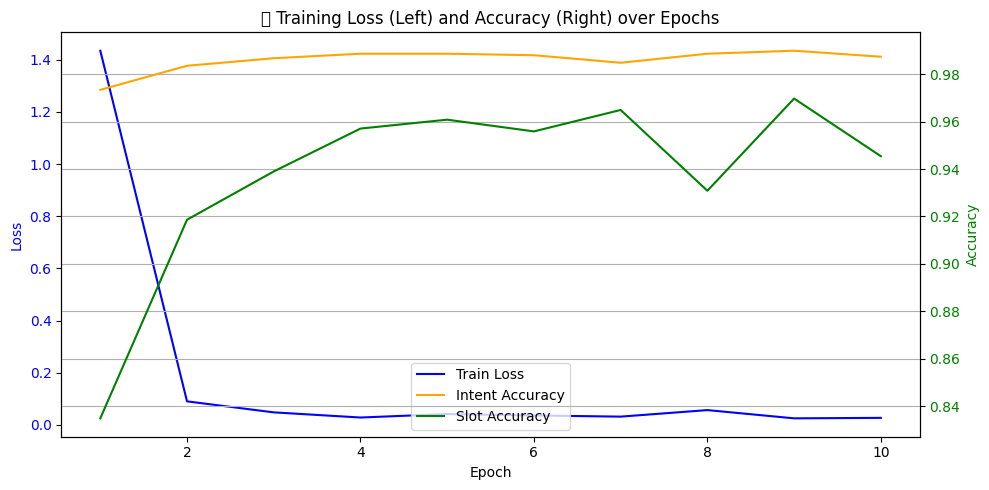

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 왼쪽 Y축: Train Loss
ax1.plot(range(1, EPOCHS+1), train_losses, color='blue', label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 오른쪽 Y축: Accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, EPOCHS+1), val_intent_accuracies, color='orange', label='Intent Accuracy')
ax2.plot(range(1, EPOCHS+1), val_slot_accuracies, color='green', label='Slot Accuracy')
ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 범례 처리
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower center')

plt.title('📊 Training Loss (Left) and Accuracy (Right) over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
from transformers import BertModel, AutoTokenizer
import pickle

# ✅ 인덱스 맵 로딩
with open(INTENT2IDX_PATH, "rb") as f:
    intent2idx = pickle.load(f)
with open(SLOT2IDX_PATH, "rb") as f:
    slot2idx = pickle.load(f)

idx2intent = {v: k for k, v in intent2idx.items()}
idx2slot = {v: k for k, v in slot2idx.items()}

# ✅ 모델 로드
model = KoBERTIntentSlotModel(num_intents=len(intent2idx), num_slots=len(slot2idx))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()


# 🧱 토큰 → 단어 병합 + 슬롯 정렬
def merge_tokens_and_slots(tokens, slot_ids, idx2slot):
    merged = []
    word = ''
    current_slot = ''

    for token, slot_id in zip(tokens, slot_ids):
        slot = idx2slot.get(slot_id, 'O')

        if token in ['[CLS]', '[SEP]', '[PAD]']:
            continue

        if token.startswith("▁"):  # 새 단어 시작
            if word:
                merged.append((word, current_slot))
            word = token[1:]
            current_slot = slot
        else:
            word += token.replace("▁", "")

    if word:
        merged.append((word, current_slot))

    return merged


# 🔮 예측 함수
def predict_top_k_intents_and_slots(text, k=3):
    encoding = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=64
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        intent_logits, slot_logits = model(input_ids, attention_mask)
        intent_probs = softmax(intent_logits, dim=1)

        # 토큰 디버깅용
        # for i, logit in enumerate(slot_logits[0]):
        #   top_id = logit.argmax().item()
        #   top_slot = idx2slot[top_id]
        #   print(f"{i}번째 토큰 → {top_slot} ({logit[top_id].item():.4f})")

        # 🎯 인텐트 예측 (Top-k)
        topk_probs, topk_indices = torch.topk(intent_probs, k, dim=1)
        intents = [(idx2intent[idx.item()], prob.item()) for idx, prob in zip(topk_indices[0], topk_probs[0])]

        # 🎯 슬롯 예측
        slot_pred_ids = torch.argmax(slot_logits, dim=2)[0].tolist()
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

        merged = merge_tokens_and_slots(tokens, slot_pred_ids, idx2slot)

    return intents, merged


# 🧪 실행 루프
if __name__ == "__main__":
    print("✨ KoBERT 기반 인텐트/슬롯 예측기입니다.")
    while True:
        text = input("\n✉️ 입력 (exit 입력 시 종료): ").strip()
        if text.lower() == "exit":
            print("👋 종료합니다.")
            break

        intents, slots = predict_top_k_intents_and_slots(text, k=3)

        print("\n🔍 예측된 인텐트 TOP 3:")
        for i, (intent, prob) in enumerate(intents, 1):
            print(f" {i}. {intent} ({prob:.4f})")

        print("\n🎯 슬롯 태깅 결과:")
        for word, slot in slots:
            print(f" - {word}: {slot}")


✨ KoBERT 기반 인텐트/슬롯 예측기입니다.


KeyboardInterrupt: Interrupted by user

In [22]:
### 추천 질문 파일 읽어 의도 분류 내용 저장


import pandas as pd
import torch
import torch.nn as nn
from torch.nn.functional import softmax
from transformers import BertModel, AutoTokenizer
import pickle
from tqdm import tqdm

# ✅ 파일 경로
FILE_PATH = "recommend_question_data.csv"  # 또는 .xlsx
SAVE_PATH = "recommend_question_with_intent.csv"

# ✅ 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 인덱스 맵 로딩
with open("best_models/intent-kobert-v1/intent2idx.pkl", "rb") as f:
    intent2idx = pickle.load(f)
with open("best_models/intent-kobert-v1/slot2idx.pkl", "rb") as f:
    slot2idx = pickle.load(f)

idx2intent = {v: k for k, v in intent2idx.items()}
idx2slot = {v: k for k, v in slot2idx.items()}

class KoBERTIntentSlotModel(nn.Module):
    def __init__(self, num_intents, num_slots):
        super().__init__()
        self.bert = BertModel.from_pretrained("skt/kobert-base-v1")
        hidden_size = self.bert.config.hidden_size

        self.intent_classifier = nn.Linear(hidden_size, num_intents)
        self.slot_classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_slots)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        pooled_output = outputs.pooler_output

        intent_logits = self.intent_classifier(pooled_output)
        slot_logits = self.slot_classifier(sequence_output)

        return intent_logits, slot_logits

# ✅ 모델 로드
model = KoBERTIntentSlotModel(num_intents=len(intent2idx), num_slots=len(slot2idx))
model.load_state_dict(torch.load("best_models/intent-kobert-v1/best_model.pt", map_location=device))
model.to(device)
model.eval()

# ✅ 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1", use_fast=False)

# 🔮 예측 함수 (의도 top-1만 사용)
def predict_intent(text):
    encoding = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=64)
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        intent_logits, _ = model(input_ids, attention_mask)
        intent_probs = softmax(intent_logits, dim=1)
        top_prob, top_index = torch.max(intent_probs, dim=1)
        predicted_intent = idx2intent[top_index.item()]
        return predicted_intent, top_prob.item()

# 📄 CSV/엑셀 파일 읽기
df = pd.read_csv(FILE_PATH)  # 또는 pd.read_excel() 사용 가능

# 🔁 각 질문에 대해 인텐트 예측
predicted_intents = []
predicted_probs = []

for question in tqdm(df['recommend_question'], desc="🔍 의도 예측 중"):
    intent, prob = predict_intent(question)
    predicted_intents.append(intent)
    predicted_probs.append(prob)

# 📎 결과 저장
df["predicted_intent"] = predicted_intents
df["intent_prob"] = predicted_probs
df.to_csv(SAVE_PATH, index=False)
print(f"✅ 예측 완료: {SAVE_PATH} 에 저장됨")


🔍 의도 예측 중:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
🔍 의도 예측 중: 100%|██████████| 100/100 [00:00<00:00, 104.97it/s]

✅ 예측 완료: recommend_question_with_intent.csv 에 저장됨
